## [Link to all chapters](https://www.kaggle.com/ustcer1984/statistics-with-python-for-data-science)

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # I like seaborn default theme

import warnings
warnings.filterwarnings('ignore')

input_path = '/kaggle/input/practical-statistics-with-python-for-data-science/'
session_times = pd.read_csv(input_path + 'web_page_data.csv')
four_sessions = pd.read_csv(input_path + 'four_sessions.csv')
click = pd.read_csv(input_path + 'click_rates.csv')

# 3 Statistical Experiments and Significance Testing

Classical statistical inference "pipeline":  
1. Formulate hypothesis
2. Design experiment
3. Collect data
4. Inference / conclusions

## 3.1 A/B Testing

#### <center>Key Terms for A/B Testing</center>
- ***Treatment***  
Something (drug, price, web headline) to which a subject is exposed.
- ***Treatment group***  
A group of subjects exposed to a specific treatment.
- ***Control group***  
A group of subjects exposed to no (or standard) treatment.
- ***Randomization***  
The process of randomly assigning subjects to treatments.
- ***Subjects***  
The items (web visitors, patients, etc.) that are exposed to treatments.
- ***Test statistic***  
The metric used to measure the effect of the treatment.

#### <center>Key Ideas</center>
- Subjects are assigned to two (or more) groups that are treated exactly alike, except that the treatment under study differs from one group to another.
- Ideally, subjects are assigned randomly to the groups.

## 3.2 Hypothesis Tests

#### <center>Key Terms for Hypothesis Tests</center>
- ***Null hypothesis***  
The hypothesis that chance is to blame.
- ***Alternative hypothesis***  
Counterpoint to the null (what you hope to prove).
- ***One-way test***  
Hypothesis test that counts chance results only in one direction.
- ***Two-way test***  
Hypothesis test that counts chance results in two directions.

## 3.2 Resampling

#### <center>Key Terms for Resampling</center>
- ***Permutation test***  
The procedure of combining two or more samples together and randomly (or
exhaustively) reallocating the observations to resamples.<br>  
*Synonyms*
    - Randomization test, random permutation test, exact test
- ***Resampling***  
Drawing additional samples (“resamples”) from an observed data set.
- ***With or without replacement***  
In sampling, whether or not an item is returned to the sample before the next draw.

### Permutation Test

To see if the statistics difference of A and B groups (can be more than 2 groups) is significant or not, we can combine the samples from all groups, randomly shuffle and assign to A, B groups (***permutation test***). Repeat it many times to see the permutation test distribution of the difference between A and B groups.  
- If the original difference is within the distribution range, we cannot reject the null hypothesis.
- If the original difference is far from the distribution range, we can reject the null hypothesis and conclude the difference between A/B groups is statistically significant.

**Example: Web Stickness**

Below data shows 2 webpage design and the amount of time people spend on them.

In [2]:
session_times.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


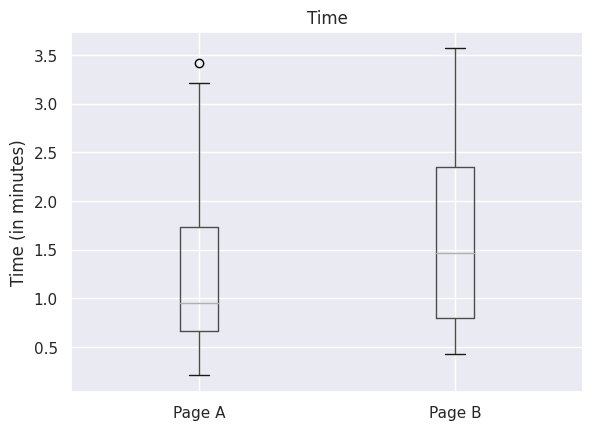

In [3]:
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('')
ax.set_ylabel('Time (in minutes)')
plt.suptitle('')
plt.show()

From above boxplot, we can see page B leads to longer sessions than page A.

In [4]:
mean_a = session_times[session_times['Page']=='Page A']['Time'].mean()
mean_b = session_times[session_times['Page']=='Page B']['Time'].mean()
mean_b - mean_a

0.3566666666666669

On average page B session time is 0.36 minutes longer than page A. The question is whether this number is statistically significant. We can do permutation test as below:

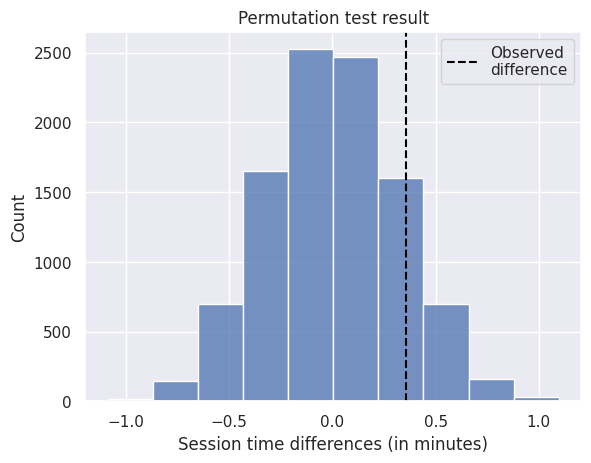

In [5]:
def perm_fun(session_times):
    # generate a new dataframe with col 'Time' shuffled
    df_new = pd.concat(
        [
            session_times['Page'], 
            session_times['Time']\
                .sample(frac=1, replace=False)\
                .reset_index(drop=True)
        ],
        axis = 1
    )
    mean_a = df_new[df_new['Page']=='Page A']['Time'].mean()
    mean_b = df_new[df_new['Page']=='Page B']['Time'].mean()
    return mean_b - mean_a

# run permutation test 10000 times
perm_diff = [perm_fun(session_times) for i in range(10000)]

# plot histplot
sns.histplot(perm_diff, bins=10)
plt.axvline(mean_b - mean_a, 
            color='black', ls='--', label='Observed\ndifference')
plt.xlabel('Session time differences (in minutes)')
plt.title('Permutation test result')
plt.legend()
plt.show()

Above plot show that mean difference of random permutations often (more than 10%) exceeds the observed difference.

In [6]:
np.mean(perm_diff > mean_b - mean_a)

0.1428

This suggests that the observed difference in session time between page A and page B is well within the range of chance variation and thus is not statistically significant.

## 3.3 Statistical Significance and p-Values

#### <center>Key Terms for Statistical Significance and p-Values</center>
- ***p-value***  
Given a chance model that embodies the null hypothesis, the p-value is the probability of obtaining results as unusual or extreme as the observed results.
- ***Alpha***  
The probability threshold of “unusualness” that chance results must surpass for actual outcomes to be deemed statistically significant.
- ***Type 1 error***  
Mistakenly concluding an effect is real (when it is due to chance).
- ***Type 2 error***  
Mistakenly concluding an effect is due to chance (when it is real).

## 3.4 t-Tests

#### <center>Key Terms for t-Tests</center>
- ***Test statistic***  
A metric for the difference or effect of interest.
- ***t-statistic***  
A standardized version of common test statistics such as means.
- ***t-distribution***  
A reference distribution (in this case derived from the null hypothesis), to which the observed t-statistic can be compared.

In [7]:
# t test statistics for above webpage example
result = stats.ttest_ind(
    session_times[session_times['Page']=='Page A']['Time'],
    session_times[session_times['Page']=='Page B']['Time'],
    equal_var=False
)
print(f'p-value for single sided test: {result.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


This result is quite close to previous permutation testing result.

**NOTE**: in above code we divide `result.pvalue` by 2. The reason is `stats.ttest_ind` null hypothesis is the 2 sample means are same (2 sides) while our null hypothesis is the 2nd sample means is not larger than 1st sample (1 side).

## 3.5 Multiple Testing

#### <center>Key Terms for Multiple Testing</center>
- ***Type 1 error***  
Mistakenly concluding that an effect is statistically significant.
- ***False discovery rate***  
Across multiple tests, the rate of making a Type 1 error.
- ***Alpha inflation***  
The multiple testing phenomenon, in which alpha, the probability of making a Type 1 error, increases as you conduct more tests.
- ***Adjustment of p-values***  
Accounting for doing multiple tests on the same data.
- ***Overfitting***  
Fitting the noise.

<br>

**Explain**  
- If you have 20 predictor variables and 1 outcome variable, all ***randomly*** generated. Then you do 20 significance tests at the alpha = 0.05 level.
    - By right no test should show positive result (*Type 1 error*), but is that the case?
- Since alpha = 0.05, the chance of true negative for each test is 0.95.
- There are 20 independent tests, so the chance of getting true negatives for all of them is 0.95^20 = 0.36.
- It means you have <span style="color:red">**64%**</span> (1 - 0.36) chance of getting at least 1 false positive (*Type 1 error*) result.
- This phenomenon is called ***alpha inflation***.

<br>

Bottom line for data scientists on multiplicity:  
- For predictive modeling, the risk of getting an illusory model whose apparent efficacy is largely a product of random chance is mitigated by cross-validation and use of a holdout sample.
- For other procedures without a labeled holdout set to check the model, you must rely on:
    - Awareness that the more you query and manipulate the data, the greater the role that chance might play.
    - Resampling and simulation heuristics to provide random chance benchmarks against which observed results can be compared.

## 3.6 Degrees of Freedom

For data science, most of the time we don't need to worry about it especially when the sample size is big enough.

There is one context, though, in which it is relevant: the use of factored variables in regression (including logistic regression). Some regression algorithms choke if exactly redundant predictor variables are present. This most commonly occurs when factoring categorical variables into binary indicators (dummies). Consider the variable “day of week.” Although there are seven days of the week, there are only six degrees of freedom in specifying day of week. For example, once you know that day of week is not Monday through Saturday, you know it must be Sunday. Inclusion of the Mon–Sat indicators thus means that *also* including Sunday would cause the regression to fail, due to a ***multicollinearity*** error.

## 3.7 ANOVA

ANOVA stands for *analysis of variance*.

#### <center>Key Terms for ANOVA</center>
- ***Pairwise comparison***  
A hypothesis test (e.g., of means) between two groups among multiple groups.
- ***Omnibus test***  
A single hypothesis test of the overall variance among multiple group means.
- ***Decomposition of variance***  
Separation of components contributing to an individual value (e.g., from the overall average, from a treatment mean, and from a residual error).
- ***F-statistic***  
A standardized statistic that measures the extent to which differences among group means exceed what might be expected in a chance model.
- ***SS***  
“Sum of squares,” referring to deviations from some average value.

<br>

**Example**

Below table shows the stickness (in seconds) of four web pages:

In [8]:
df = four_sessions.copy()
df['idx'] = df.groupby('Page').cumcount()
df.pivot(index='idx', columns='Page', values='Time')

Page,Page 1,Page 2,Page 3,Page 4
idx,,,,
0,164,178,175,155
1,172,191,193,166
2,177,182,171,164
3,156,185,163,170
4,195,177,176,168


If we want to study if their means are significant different, one way is to compare each 2 pages group (e.g. Page 1 vs. Page 2). We will have 6 groups in this case. 

However, the more *pairwise* comparisons we make, the greater potential to get at least one *Type 1 error* due to random chance as discussed in **Multiple Testing**. So we need a single overall test, which is what ANOVA does.

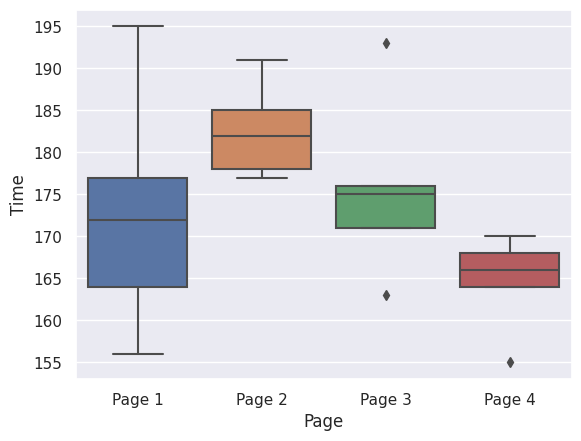

In [9]:
sns.boxplot(four_sessions, x='Page', y='Time')
plt.show()

Procedure of ANOVA by permutation testing for above example:  
1. Combine all the data together in a single box.
2. Shuffle and draw out four resamples of five values each.
3. Record the mean of each of the four groups.
4. Record the variance among the four group means.
5. Repeat steps 2–4 many (say, 1,000) times.

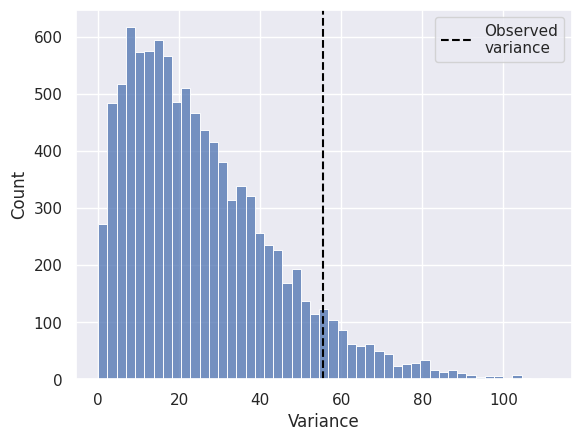

p value = 0.0741


In [10]:
observed_variance = four_sessions.groupby('Page').mean().var().iloc[0]

def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].to_numpy())
    return df.groupby('Page').mean().var().iloc[0]

perm_variance = [perm_test(four_sessions) for i in range(10000)]

# plot histgram
sns.histplot(perm_variance)
plt.axvline(observed_variance, ls='--', color='black', 
            label='Observed\nvariance')
plt.xlabel('Variance')
plt.legend()
plt.show()

print(f'p value = {np.mean(perm_variance > observed_variance):.4f}')

If alpha = 0.05, then p value > alpha, so the difference is not statistically significant.

<br>

### F-statistic

ANOVA can be calculated based on *F-statistic*. 

The F-statistic is based on the ratio of the variance across group means to the variance due to residual error. The higher thsi ratio, the more statistically significant the result. If the data follows a normal distribution, then statistical theory dictates that the statistic should have a certain distribution. Based on this, it is possible to compute a p-value.

In [11]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


p-value = 0.0776, which is close to previous permutation testing result.

## 3.8 Chi-Square Test

The chi-square test is used with count data to test how well it fits some expected distribution. The most common use of the chi-square statistic in statistical practice is with $r\times c$ contingency tables, to assess whether the null hypothesis of independence among variables is reasonable.

### Resampling Approach

Below is the testing result on three different headlines on 1,000 visitors each.

In [12]:
observed = click.pivot(index='Click', columns='Headline', values='Rate')
observed

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


***Null hypothesis***  
- All three headlines share the same click rate.
- The "expected" click rate is 34/3,000

Below table shows the expected values.

In [13]:
expected = observed.copy()
expected.iloc[0, :] = [34/3] * 3
expected.iloc[1, :] = [1000 - 34/3] *3
expected

Headline,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


The *Pearson residual* is defined as:
$$R=\frac{\text{Observed}-\text{Expected}}{\sqrt{\text{Expected}}}$$

Below table shows the Pearson residuals.

In [14]:
residuals = (observed-expected)/np.sqrt(expected)
residuals

Headline,Headline A,Headline B,Headline C
Click,,,
Click,0.792118,-0.990148,0.198030
No-click,-0.084809,0.106012,-0.021202


The chi-square statistic is defined as the sum of the squared Pearson residuals:
$$X=\sum_{i}^{r}\sum_{j}^{c}R^2$$
where $r$ and $c$ are the number of rows and columns, respectively.

In [15]:
print(f'Chi-Square statistic = {(residuals**2).sum().sum():.3f}')

Chi-Square statistic = 1.666


How to calculate p-value? We can test with resampling algorithm:  
1. Constitute a box with 34 ones (clicks) and 2,966 zeros (no clicks).
2. Shuffle, take three separate samples of 1,000, and count the clicks in each.
3. Find the squared differences between the shuffled counts and the expected counts and sum them.
4. Repeat steps 2 and 3, say, 1,000 times.
5. How often does the resampled sum of squared deviations exceed the observed? That’s the p-value.

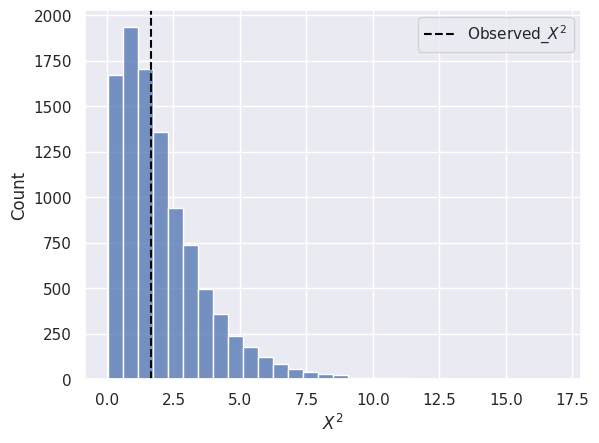

p value = 0.4896


In [16]:
observed_chi2 = (residuals**2).sum().sum()

box = np.array([True] * 34 + [False] * 2966)

def perm_fun(box):
    samples = [np.random.permutation(box)[:1000] for i in range(3)]
    clicks = [np.sum(sample) for sample in samples]
    noclicks = [1000 - click for click in clicks]
    chi2 = 0
    for click in clicks:
        chi2 += (click - 34/3)**2/(34/3)
    for noclick in noclicks:
        chi2 += (noclick - 2966/3)**2/(2966/3)
    return chi2

perm_chi2 = [perm_fun(box) for i in range(10000)]

# plot histgram
sns.histplot(perm_chi2, bins=30)
plt.axvline(observed_chi2, ls='--', color='black', 
            label='Observed_$X^2$')
plt.xlabel('$X^2$')
plt.legend()
plt.show()

print(f'p value = {np.mean(perm_chi2 > observed_chi2):.4f}')

If alpha = 0.05, then p-value > alpha, indicating the click rates of the three different headlines are NOT statitically different.

### Statistical Theory

The chi-square statistic can be approximated by a *chi-square distribution*. For a contingency table, the degrees of freedom are related to the number of rows (r) and columns (c) as follows:
$$\text{degrees of freedom}=(r-1)\times (c-1)$$

In [17]:
chisq, pvalue, df, expected = stats.chi2_contingency(observed)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


The p-value is a little less than the resampling p-value; this is because the chi-square distribution is only an approximation of the actual distribution of the statistic.

## 3.9 Multi-Arm Bandit Algorithm

#### <center>Key Terms for Multi-Arm Bandits</center>
- ***Multi-arm bandit***  
An imaginary slot machine with multiple arms for the customer to choose from, each with different payoffs, here taken to be an analogy for a multitreatment experiment.
- ***Arm***  
A treatment in an experiment (e.g., “headline A in a web test”).
- ***Win***  
The experimental analog of a win at the slot machine (e.g., “customer clicks on the link”).

<br>

Epsilon-greedy algorithm for an A/B test:  
1. Generate a uniformly distributed random number between 0 and 1.
2. If the number lies between 0 and epsilon (where epsilon is a number between 0 and 1, typically fairly small), flip a fair coin (50/50 probability), and:  
a. If the coin is heads, show offer A.  
b. If the coin is tails, show offer B.  
3. If the number is ≥ epsilon, show whichever offer has had the highest response rate to date.

<br>

#### <center>Key Ideas</center>
- Traditional A/B tests envision a random sampling process, which can lead to excessive exposure to the inferior treatment.
- Multi-arm bandits, in contrast, alter the sampling process to incorporate information learned during the experiment and reduce the frequency of the inferior treatment.
- They also facilitate efficient treatment of more than two treatments.
- There are different algorithms for shifting sampling probability away from the inferior treatment(s) and to the (presumed) superior one.

## 3.10 Power and Sample Size

#### <center>Key Terms for Power and Sample Size</center>
- ***Effect size***  
The minimum size of the effect that you hope to be able to detect in a statistical test, such as “a 20% improvement in click rates.”
- ***Power***  
The probability of detecting a given effect size with a given sample size.
- ***Significance level***  
The statistical significance level at which the test will be conducted.

<br>

Intuitive alternative approach to find necessary sample size:  
1. Start with some hypothetical data that represents your best guess about the data that will result (perhaps based on prior data)—for example, a box with 20 ones and 80 zeros to represent a .200 hitter, or a box with some observations of “time spent on website.”
2. Create a second sample simply by adding the desired effect size to the first sample—for example, a second box with 33 ones and 67 zeros, or a second box with 25 seconds added to each initial “time spent on website.”
3. Draw a bootstrap sample of size n from each box.
4. Conduct a permutation (or formula-based) hypothesis test on the two bootstrap samples and record whether the difference between them is statistically significant.
5. Repeat the preceding two steps many times and determine how often the difference was significant—that’s the estimated power.

<br>

For calculating power or required sample size, there are four moving
parts:  
- Sample size
- Effect size you want to detect
- Significance level (alpha) at which the test will be conducted
- Power

Specify any three of them, and the fourth can be calculated.

**Example**  
- The impression rate of new ad is supposed to be 10% higher than original ad.
    - Original ad impression rate: 1.1%
    - New ad imporession rate (supposed): 1.21%
- Find the sample size of a test with power of 80% and significance level 0.05.

In [18]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(
    effect_size = effect_size,
    alpha = 0.05,
    power = 0.8,
    alternative = 'larger'
)
print(f'Sample size: {result:.3f}')

Sample size: 116602.393
